
# Protocol 1: assessment of cell type replicability with unsupervised MetaNeighbor

Protocol 1 demonstrates how to compute and visualize cluster replicability across 4 human pancreas datasets. We will show steps detailing how to install MetaNeighbor, how to compute and interpret MetaNeighbor AUROCs. All code blocks can be run in a Jupyter notebook, python or ipython interpretor or in a script run at the command line.

## Step 0: Installation of MetaNeighbor and packages used in the protocol

1. We start by installing the latest MetaNeighbor package from the Gillis lab GitHub page.


In [ ]:
!pip install git+https://github.com/bharris12/pyMN#egg=pymn

2. Next we need to import other packages needed to run this analysis, all of these are required by pyMN anyway so you should have them if it successfully installs

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pymn

In /home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


In [3]:
%matplotlib inline

3. Here we set up our plotting settings, these are our preferences

In [4]:
#These save characters as text in PDFs
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

#These change plot aesthetics

sns.set(style='white', font_scale=1.25)
plt.rc("axes.spines", top=False, right=False)
plt.rc('xtick', bottom=True)
plt.rc('ytick', left=True)

## Step 1: Downloading the Hemberg scRNAseq data

We consider 4 pancreatic datasets along with their independent annotation (from the original publication). MetaNeighbor expects a gene x cell matrix encapsulated in a anndata format. In python we reccomend using the anndata object. It is works well with the popular scRNAseq analysis package Scanpy. The 4 datasets are best aquired using the R package scRNAseq. In the equilavent protocol the R version of MetaNeighbor we outline how to aquire and preprocess each individual dataset. Merging the R SingleCellExperiement objects proves to be quite difficult that protocol provides a tutorial on that. Merging python anndata objects is relatively straightforward, but if you have difficulty the the [anndata documentation](https://anndata.readthedocs.io/en/stable/concatenation.html) has a section dedicated to it.

4. First we need to download the data using `curl`

In [12]:
!curl ####LINK -o FILENAME

curl: try 'curl --help' or 'curl --manual' for more information


## Step 2: Hierarchical cluster replicability analysis

5. We load the previously created pancreas dataset.

In [5]:
adata = sc.read_h5ad(
    '/tyrone-data/bharris/metaneighbor_protocol_data/hemberg.h5ad') #Temporary until hosted file

In [6]:
adata.obs.columns = adata.obs.columns.astype(str)

Here you can see that we have an AnnData object iwth 15,793 cells and 15,295 genes

It has two observation features: `cell.type` and `study_id`

In [7]:
adata

AnnData object with n_obs × n_vars = 15793 × 15295
    obs: 'cell.type', 'study_id'

6. Data must be passed as a string or integer to MetaNeigbhor fast version for the computation to be sped up

In [8]:
adata.obs['cell.type'] = adata.obs['cell.type'].astype(str)
adata.obs['study_id'] = adata.obs['study_id'].astype(str)

7. To perform neighbor voting, MetaNeighbor builds a cell-cell similarity network, which we defined as the Spearman correlation over a user-defined set of genes. We found that we obtained best results by picking genes that are highly variable across datasets, which can be picked using the "variableGenes" function.


>**NOTE**: This is the one function that differs slightly from the R version. The quantile function in R defaults to a behavoir that is not native to any standard python packages, thus the variable gene list is slightly different between the python and R versions. Overall this does not appear to affect the results significantly. While the AUROCs will not be identical they are extremely similar and in the completed analysis does not change which clusters replicate or metacluster assignments

In [9]:
%%time
pymn.variableGenes(adata, study_col='study_id')

CPU times: user 30.2 s, sys: 2.98 s, total: 33.2 s
Wall time: 4.17 s


In [10]:
# r_hvg = np.genfromtxt(
#     '/tyrone-data/bharris/metaneighbor_protocol_data/pancreas_hvg_R.csv',
#     dtype=str)

# adata.var.highly_variable = np.in1d(adata.var_names, r_hvg)

The function returns a list of 600 (736 in the python version) genes that were detected as highly variable in each of the 4 datasets.

8. The data and a set of biological meaningful genes is all we need to run MetaNeighbor and obtain cluster similarities.

In [10]:
%%time
pymn.MetaNeighborUS(adata,
                          study_col='study_id',
                          ct_col='cell.type',
                          fast_version=True)

2020-09-24 11:13:39,862 - Making output Symmetric
2020-09-24 11:13:39,871 - Done Computing MetaNeighbor


CPU times: user 10.6 s, sys: 705 ms, total: 11.3 s
Wall time: 933 ms


Cluster similarities are defined as an Area Under the ROC curve (AUROC), which range between 0 and 1. The cross-dataset voting framework makes it batch-effect free (very different from average correlation)

9. For ease of interpretation the results can be visualized as a symmetric heatmap, where rows and columns are clusters from all datasets.

In [11]:
adata

AnnData object with n_obs × n_vars = 15793 × 15295
    obs: 'cell.type', 'study_id'
    var: 'highly_variable'
    uns: 'MetaNeighborUS', 'MetaNeighborUS_params'

/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/matrix.py:1215: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


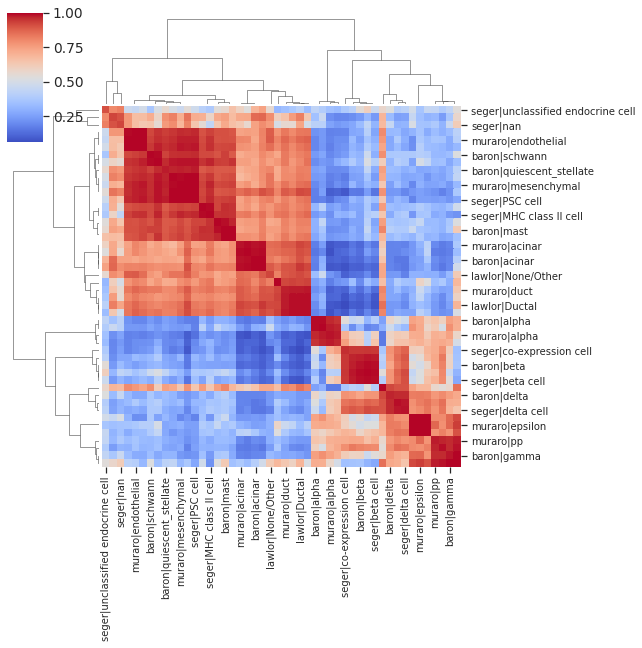

In [12]:
pymn.plotMetaNeighborUS(adata, figsize=(10, 10), cmap='coolwarm', fontsize=10)

In the heatmap, the color of each square indicates the proximity of a pair of cluster, ranging from blue (low similarity) to red (high similarity). For example, "serger|gamma cell" (bottom row) is highly similar to "muraro|pp" (2nd column from the right) but very dissimilar from "muraro|ductal" (middle column). To group similar clusters together, "plotHeatmap" applies hierarchical clustering on the AUROC matrix. On the heatmap, we see two red blocks that indicate clear hierarchical structure in the data, with endocrine cell types clustering together (e.g., alpha, beta, gamma) and mesenchymal cells on the other side (e.g., amacrine, ductal, endothelial). Note that each red block is composed of smaller red blocks, indicating that clusters can be matched at an even higher resolution. We also see some off-diagonal patterns (e.g., lawlor|Gamma/PP, lawlor|Delta), which generally indicate the presence of doublets or contamination (presence of cells from other cell types), but what matters here is the clear presence of red blocks, which is a strong indicator of replicability.

10. To identify pairs of replicable clusters, we rely on a simple heuristics: a pair of cluster is replicable if they are reciprocal top hits (they preferentially vote for each other) and the AUROC exceeds a given threshold value (in our experience, 0.95 is a good heuristic value).

In [13]:
pymn.topHits(adata, study_col='study_id', ct_col='cell.type')


adata.uns['MetaNeighborUS_topHits']

/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/bharris/miniconda3/envs/python3/lib/python3.7/site-packages/pandas/core/indexing.py:964: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Study_ID|Celltype_1,Study_ID|Celltype_2,Mean_AUROC,Match_type
0,seger|epsilon cell,muraro|epsilon,1.00,Reciprocal_top_hit
1,baron|epsilon,seger|epsilon cell,1.00,Above_0.95
2,seger|PSC cell,lawlor|Stellate,1.00,Reciprocal_top_hit
3,seger|endothelial cell,muraro|endothelial,1.00,Reciprocal_top_hit
4,muraro|mesenchymal,seger|PSC cell,1.00,Above_0.95
5,seger|mast cell,baron|mast,1.00,Reciprocal_top_hit
6,baron|activated_stellate,seger|PSC cell,1.00,Above_0.95
7,baron|endothelial,muraro|endothelial,1.00,Above_0.95
8,lawlor|Gamma/PP,baron|gamma,1.00,Reciprocal_top_hit
9,lawlor|Acinar,baron|acinar,1.00,Reciprocal_top_hit


We find a long list of replicable clusters within endocrine and mesenchymal cell types. This list provides strong evidence that these cell types are robust, as they are identified across all datasets with high AUROC.

14. In the case where there is a clear structure in the data (endocrine vs mesenchymal here), we can refine AUROCs by splitting the data. AUROCs have a simple interpretation: an AUROC of 0.6 indicates that cells from a given cell type are ranked in front of 60% of other test cells. However, this interpretation is out-group dependent: because endocrine cells represent ~65% of cells, even unrelated mesenchymal cell types will have an AUROC > 0.65, just because they will always be ranked in front of endocrine cells.

By starting with the full datasets, we uncovered the global structure in the data. However, to evaluate replicability of endocrine cell types and reduce dataset composition effects, we can make the assessment more stringent by restricting the outgroup to close cell types, i.e. by keeping only endocrine subtypes. We split cell types in two by using the "splitClusters" function and retain only endocrine cell types:

In [14]:
level1_split = pymn.splitClusters(adata, k=2, save_uns=False)
level1_split

[array(['baron|acinar', 'baron|activated_stellate', 'baron|ductal',
        'baron|endothelial', 'baron|macrophage', 'baron|mast',
        'baron|quiescent_stellate', 'baron|schwann', 'baron|t_cell',
        'lawlor|Acinar', 'lawlor|Ductal', 'lawlor|None/Other',
        'lawlor|Stellate', 'muraro|acinar', 'muraro|duct',
        'muraro|endothelial', 'muraro|mesenchymal', 'muraro|nan',
        'muraro|unclear', 'seger|MHC class II cell', 'seger|PSC cell',
        'seger|acinar cell', 'seger|ductal cell', 'seger|endothelial cell',
        'seger|mast cell', 'seger|nan', 'seger|unclassified cell',
        'seger|unclassified endocrine cell'], dtype=object),
 array(['baron|alpha', 'baron|beta', 'baron|delta', 'baron|epsilon',
        'baron|gamma', 'lawlor|Alpha', 'lawlor|Beta', 'lawlor|Delta',
        'lawlor|Gamma/PP', 'muraro|alpha', 'muraro|beta', 'muraro|delta',
        'muraro|epsilon', 'muraro|pp', 'seger|alpha cell',
        'seger|beta cell', 'seger|co-expression cell', 'seger|del

In [15]:
first_split = level1_split[1]

By outputting "level1_split" (not shown here), we found that the clusters were nicely split between mesenchymal and endocrine, and that endocrine clusters where in the second element of the list.

15. We repeat the MetaNeighbor analysis on endocrine cells only. First, we subset the data to the endocrine cell types (stored in "first_split").

In [16]:
to_keep = np.in1d(
    pymn.join_labels(adata.obs['study_id'].values,
                     adata.obs['cell.type'].values), first_split)
subdata = adata[to_keep, :]
subdata.shape

(9341, 15295)

The new dataset contains the 9341 putative endocrine cells.

16. To focus on variability that is specific to endocrine cells, we re-pick highly variable genes:

In [17]:
pymn.variableGenes(subdata, study_col='study_id')

Trying to set attribute `.var` of view, copying.


17. Finally we recompute cluster similarities and visualize AUROCs.

In [18]:
%%time
res = pymn.MetaNeighborUS(subdata,
                          study_col='study_id',
                          ct_col='cell.type',
                          fast_version=True)


2020-09-24 11:13:59,713 - Making output Symmetric
2020-09-24 11:13:59,717 - Done Computing MetaNeighbor


CPU times: user 3.46 s, sys: 243 ms, total: 3.7 s
Wall time: 338 ms


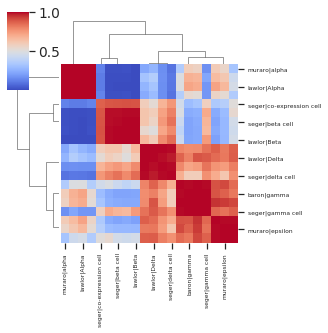

In [19]:
pymn.plotMetaNeighborUS(subdata,cmap='coolwarm')

The resulting heatmap illustrates an example of a strong set of replicating clusters: when the assessment become more stringent (restriction to closely related cell types), the similarity of replicating clusters remains strong (AUROC~1 for alpha, beta, gamma, delta and epsilon cells) while the cross-cluster similarity has decreased (shift from red to blue, e.g. similarity of alpha and beta clusters has shifted from orange/red to dark blue) by virtue of zooming in on a subpart of the dataset.

18. We can continue to zoom in as long as there are at least two cell types per dataset:

In [20]:
level2_split = pymn.splitClusters(subdata, k=3, save_uns=False)
my_split = level2_split[2]
keep_cell = np.in1d(
    pymn.join_labels(adata.obs['study_id'], adata.obs['cell.type']), my_split)
subdata = adata[keep_cell, ]
pymn.MetaNeighborUS(subdata,
                          study_col='study_id',
                          ct_col='cell.type',
                          fast_version=True)

2020-09-24 11:14:00,283 - Making output Symmetric
2020-09-24 11:14:00,285 - Done Computing MetaNeighbor
Trying to set attribute `.uns` of view, copying.


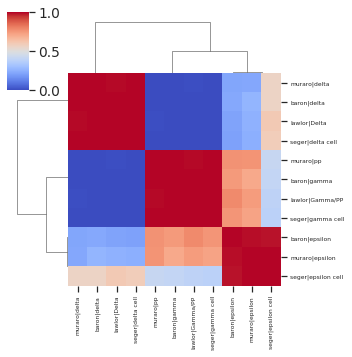

In [21]:
pymn.plotMetaNeighborUS(subdata, cmap='coolwarm')

Here we removed the alpha and beta cells (representing close to 85% of endocrine cells) and validate that, even when restricting to neighboring cell types, there is still a clear distinction between delta, gamma and epsilon cells (AUROC ~ 1).

## Step 3: stringent assessment of replicability with one-vs-best AUROCs

In the previous section, we created progressively more stringent replicability assessments of replicability by selecting more and more specific subsets of related cell types. As an alternative, we provide the "one-vs-best" parameter, which offers similar results without having to restrict the dataset by hand. In this scoring mode, MetaNeighbor will automatically identify the two closest matching clusters in each dataset and compute an AUROC based on the voting result for cells from the closest match against cells from the second closest match. Essentially, we are asking how easily a cluster can be distinguished from its closest neighbor.

19. To obtain one-vs-best AUROCs, we run the same command as before with two additional parameters: "one_vs_best = TRUE" and "symmetric_output = FALSE".

In [22]:
%%time
pymn.MetaNeighborUS(adata,
                    study_col='study_id',
                    ct_col='cell.type',
                    fast_version=True,
                    symmetric_output=False,
                    one_vs_best=True)

2020-09-24 11:14:04,365 - Done Computing MetaNeighbor


CPU times: user 40.6 s, sys: 2.55 s, total: 43.1 s
Wall time: 3.43 s


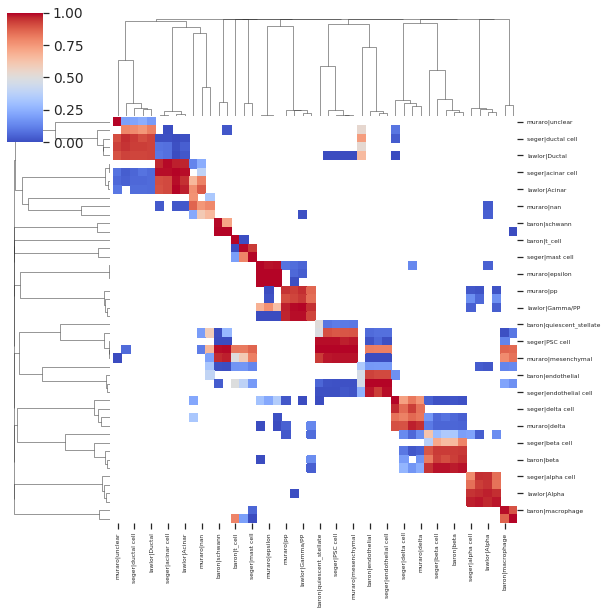

In [23]:
pymn.plotMetaNeighborUS(adata, cmap='coolwarm', figsize=(10, 10), mn_key='MetaNeighborUS_1v1')

The interpretation of the heatmap is slightly different compared to one-vs-all AUROCs. First, since we only compare the two closest clusters, most cluster combinations are not tested (NAs, shown in gray on the heatmap). Second, by setting "symmetric_output=FALSE", we broke the symmetric of the heatmap: train clusters are shown as columns and test clusters are shown as rows. Since each cluster is only tested against two clusters in each test dataset (closest and second closest match), we have 8 values per column (2 per dataset).

This representation helps to rapidly identify a cluster's closest hits as well as their closest outgroup. For example, ductal cells (2nd red square from the top right) strongly match with each other (one-vs-best AUROC>0.8) and acinar cells are their closest outgroup (blue segments in the same column). The non-symmetric view also makes it clear when best hits are not reciprocal. For example, mast cells (first two columns) heavily vote for "lawlor|Stellate" and "muraro|mesenchymal", but this vote is not reciprocal. This pattern indicates that the mast cell type is missing in the Lawlor and Muraro datasets (or that there are only a few mast cells that have been wrongly assigned to another cell type).

20. When using one-vs-best AUROCs, we recommend extracting replicating clusters as meta-clusters. Clusters are part of the same meta-cluster if they are reciprocal best hits. Note that if cluster 1 is the reciprocal best hit of 2 and 3, all three clusters are part of the same meta-cluster, even if 2 and 3 are not reciprocal best hits. To further filter for strongly replicating clusters, we specify an AUROC threshold (in our experience, 0.7 is a strong one-vs-best AUROC threshold).

In [24]:
adata

AnnData object with n_obs × n_vars = 15793 × 15295
    obs: 'cell.type', 'study_id'
    var: 'highly_variable'
    uns: 'MetaNeighborUS', 'MetaNeighborUS_params', 'MetaNeighborUS_topHits', 'MetaNeighborUS_1v1'

In [25]:
pymn.extractMetaClusters(adata, threshold=.7)
pymn.score_meta_clusters(adata, best_hits='MetaNeighborUS_1v1', mn_key='MetaNeighborUS_params')
adata.uns['MetaNeighborUS_metacluster_scores']

,clusters,n_studies,score
metacluster_1,"[lawlor|Acinar, seger|acinar cell, muraro|acin...",4,0.964499
metacluster_2,"[lawlor|Stellate, seger|PSC cell, muraro|mesen...",4,0.966342
metacluster_3,"[muraro|alpha, seger|alpha cell, baron|alpha, ...",4,0.929227
metacluster_4,"[lawlor|Beta, seger|beta cell, baron|beta, mur...",4,0.890479
metacluster_5,"[baron|delta, seger|delta cell, lawlor|Delta, ...",4,0.873855
metacluster_6,"[seger|ductal cell, lawlor|Ductal, baron|ducta...",4,0.895828
metacluster_7,"[muraro|endothelial, baron|endothelial, seger|...",3,0.962885
metacluster_8,"[baron|epsilon, muraro|epsilon, seger|epsilon ...",3,0.997211
metacluster_9,"[muraro|pp, seger|gamma cell, lawlor|Gamma/PP,...",4,0.94572
metacluster_10,"[baron|macrophage, seger|MHC class II cell]",2,0.940192


The "scoreMetaClusters" provides a good summary of meta-clusters, ordering cell types by the number of datasets in which they replicate, then by average AUROC. We find 12 cell types that have strong support across at least 2 datasets, with 7 cell types replicating across all 4 datasets. 8 cell types are tagged as "outlier", as they had no strong match. These cell types usually contain doublets, low quality cells or contaminated cell types. The replicability structure described here can be summarized as an Upset plot.

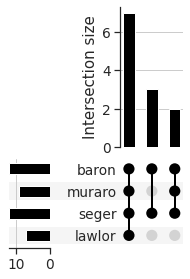

In [26]:
pymn.plotUpset(adata)

Meta-clusters can also be visualized as heatmaps (called "cell-type badges") with the "plotMetaClusters" function (full output not shown here). Each badge shows an AUROC heatmap restricted to each specific meta-cluster. These badges help diagnose cases where AUROCs are lower in a specific train or test dataset. For example, the "muraro|duct" cell type has systematically lower AUROCs, likely indicating the presence of contaminating cells in another cell type (probably "muraro|unclear", referring to the original heatmap).

In [ ]:
##Note yet implemented
# pdf("meta_clusters.pdf")
# plotMetaClusters(mclusters, best_hits)
# dev.off()

21. The last visualization is an alternative representation of the AUROC heatmap as a graph, which is particularly useful for large datasets. In this graph, top votes (AUROC > 0.5) are shown in black, while outgroup votes (AUROC < 0.5) are shown in orange. To highlight close calls, we recommend keeping only strong outgroup votes, here with AUROC >= 0.4.

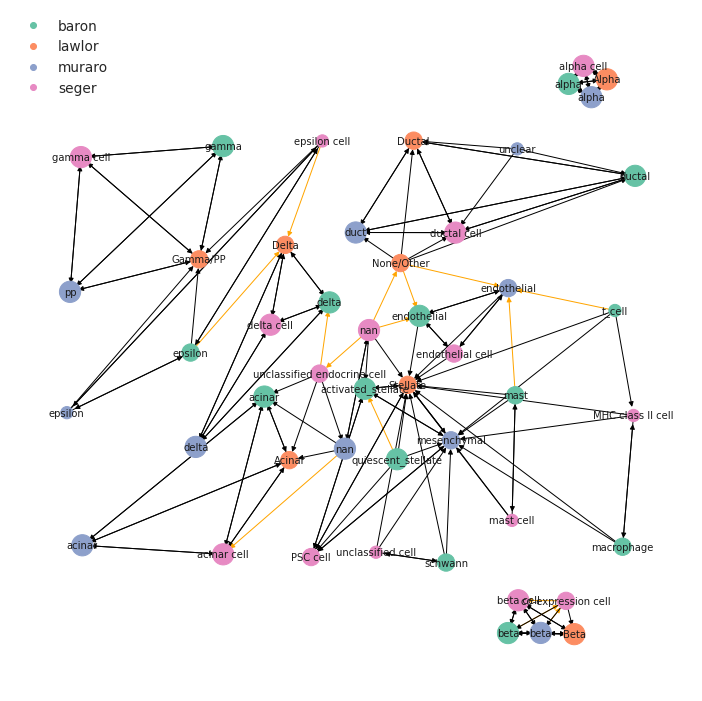

In [44]:
pymn.makeClusterGraph(adata, low_threshold=.3)
pymn.plotClusterGraph(adata, font_size=10, figsize=(10, 10))

We note that there are several orange edges, indicating that some cell types had two close matches. To investigate the origin of these close calls, we take "baron|quiescent_stellate" as our cluster of interest (coi), query its closest neighbors with "extendClusterSet", then zoom in on its subgraph with "subsetClusterGraph".

{'baron|epsilon'}


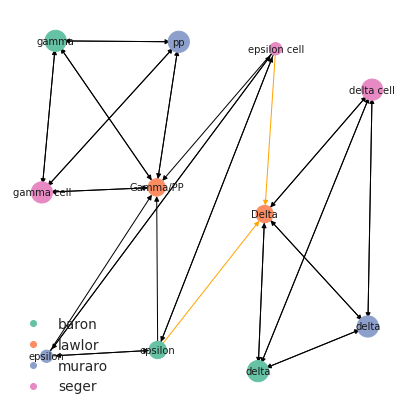

In [141]:
coi = "baron|epsilon"
coi = extendClusterSet(adata=adata, coi=coi, max_neighbor_distance=2)
pymn.plotClusterGraph(adata, node_list=coi, font_size=10, figsize=(6, 6))

Here the explanation of the presence of the orange edges is relatively straightforward: the epsilon cell type seems to be missing in the Lawlor dataset, so votes from "baron|epsilon" were equally split between "Lawlor|Gamma/PP" and "Lawlor|Alpha".

In general, the cluster graph can be used to understand how meta-clusters are extracted, why some clusters are tagged and outliers and diagnose problems where resolution of cell types differs across datasets.